## This notebook explores the effect of the objective distribution on the algorithm.

The reaction space for a transformation contains substrates that provide high performance and substrates that will perform poorly. The ratio of these compounds is unknown before a scope is investigated. The scope selection algorithm would ideally perform well for any distribution of the objective values.

To investigate the influence of the distribution of objective values, subsets with different distributions were selected from the full dataset.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from Code.benchmark import Benchmark
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import os
import ast
from scipy.stats import skew
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import colorsys

# Doyle colors
doyle_colors = ["#CE4C6F", "#1561C2", "#188F9D","#C4ADA2","#515798", "#CB7D85", "#A9A9A9"]
# extension of palette with lighter and darker versions
def adjust_lightness(color, factor=1.2):
    """
    Function to make colors lighter (factor > 1) or darker (factor < 1).
    """
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(0, min(1, l * factor))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return mcolors.to_hex((r, g, b))

lighter = [adjust_lightness(c, 1.2) for c in doyle_colors]
darker  = [adjust_lightness(c, 0.7) for c in doyle_colors]
all_colors = doyle_colors + darker[::-1] + lighter[::-1] 

# Save the categorical colormap
cat_cmap = ListedColormap(all_colors, name="Doyle_cat")
plt.colormaps.register(cat_cmap)

# Define and save a continuous colormap
colors = [doyle_colors[1],"#FFFFFFD1",doyle_colors[0]]
cont_cmap = LinearSegmentedColormap.from_list("Doyle_cont", colors)
plt.colormaps.register(cont_cmap)

wdir = Path(".")

# General plt parameters
plt.rcParams.update({
    "axes.titlesize": 20,        # Subplot title
    "axes.labelsize": 16,        # X and Y labels
    "figure.titlesize": 24,      # Suptitle
    "xtick.labelsize": 14,       # X tick labels
    "ytick.labelsize": 14,       # Y tick labels
    "legend.fontsize": 14,       # Legend text
    "legend.title_fontsize": 14  # Legend titles
})

## Create datasets with different distributions

The full, unfiltered datast has 2055 entries.
Skewness: -0.18041


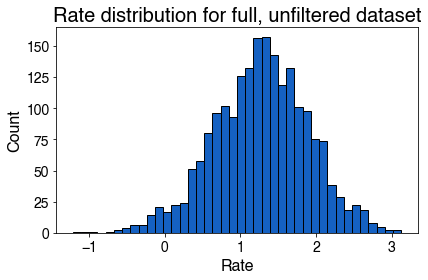

In [2]:
# Read in the unfiltered dataset
df_original = pd.read_csv("./../0_Data/Datasets/Datasets_Initial_Trends/ArI_data_dft_unfiltered.csv",index_col=0,header=0)
# sort the dataframe by rate
df_original = df_original.sort_values(by="rate")
print(f"The full, unfiltered datast has {len(df_original)} entries.")
print(f"Skewness: {round(skew(df_original['rate']),5)}")
plt.figure(figsize=(6, 4))
plt.title("Rate distribution for full, unfiltered dataset")
plt.hist(df_original["rate"], color=all_colors[1], bins=40, edgecolor="k")
plt.xlabel("Rate")
plt.ylabel("Count")
plt.tick_params(axis='both', which='major')
plt.tight_layout()
plt.show()

Skewness of the uppper subset: 0.91321
Size of this subset: 1028 samples
Mean rate of this subset: 1.765


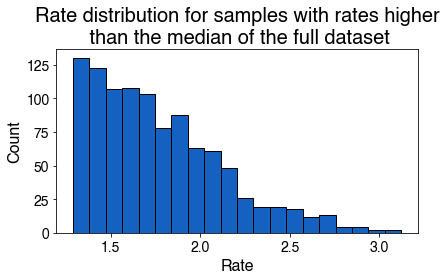

In [3]:
# Get a dataset with strong skewness by taking all samples with lower performance than the median
df_pruned = df_original.copy(deep=True)
df_pruned = df_pruned.iloc[-1028:]
df_pruned.to_csv("./../0_Data/Datasets/Datasets_Initial_Trends/ArI_data_dft_filtered_skewed_low.csv",index=True,header=True)
print(f"Skewness of the uppper subset: {round(skew(df_pruned['rate']),5)}")
print(f"Size of this subset: {len(df_pruned)} samples")
print(f"Mean rate of this subset: {round(df_pruned['rate'].mean(),3)}")
plt.figure(figsize=(6, 4))
plt.title("Rate distribution for samples with rates higher\n than the median of the full dataset")
plt.hist(df_pruned["rate"], color=all_colors[1], bins=20, edgecolor="k")
plt.xlabel("Rate")
plt.ylabel("Count")
plt.tick_params(axis='both', which='major')
plt.tight_layout()
plt.show()


This subset is highly skewed, but similar skewness can be observed in some experimental datasets such as certain reaction conditions in the Amide dataset and the XEC datasets that are explored in this work.

While the subset is skewed towards low performance, but we could also directly use it as a dataset skewed towards high performance by inverting the ranks of the rate labels. This has the advantage that both sets have exactly the same samples which makes the Vendi scores fully comparable.

Skewness of the inverted subset: -0.91321
Size of this subset: 1028 samples
Mean rate of this subset: 2.646


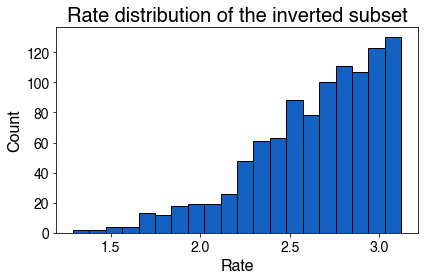

In [4]:
df_inverted = df_pruned.copy(deep=True)
# Get the extreme values
min_val = df_inverted["rate"].min()
max_val = df_inverted["rate"].max()
# Invert the distribution
df_inverted["rate"] = df_inverted["rate"].apply(lambda x: min_val + max_val - x)
df_inverted.to_csv("./../0_Data/Datasets/Datasets_Initial_Trends/ArI_data_dft_filtered_skewed_high.csv",index=True,header=True)
print(f"Skewness of the inverted subset: {round(skew(df_inverted['rate']),5)}")
print(f"Size of this subset: {len(df_inverted)} samples")
print(f"Mean rate of this subset: {round(df_inverted['rate'].mean(),3)}")

plt.figure(figsize=(6, 4))
plt.title("Rate distribution of the inverted subset")
plt.hist(df_inverted["rate"], color=all_colors[1], bins=20, edgecolor="k")
plt.xlabel("Rate")
plt.ylabel("Count")
plt.tick_params(axis='both', which='major')
plt.tight_layout()
plt.show()

## Run scopes with the skewed subset

In [5]:
# skewness = ["low_performance", "high_performance"]
# for trend in skewness:
#     # dictionary with the different batches and the possible Vendi pruning fractions (larger batch = less rounds --> more pruning possible)
#     batch_pruning_combinations = {2: [0,10,20], 3: [0,10,20,30,40], 4: [0,10,20,30,40,50]}
#     for batch in batch_pruning_combinations.keys():
#         # run the scopes with the different settings
#         Benchmark().collect_data(
#             filename_labelled = f"./../0_Data/Datasets/Datasets_Initial_Trends/ArI_data_dft_filtered_skewed_{trend.split('_')[0]}.csv",  
#             name_results = f"./Results_Data/Distribution_Dependence/{trend}/30balanced_b{batch}",  
#             objectives=['rate'],  
#             budget = 30,
#             batches= [batch],
#             Vendi_pruning_fractions = batch_pruning_combinations[batch],
#             seeds = 20,
#             acquisition_function_mode= "balanced",
#             pruning_metric= "vendi_batch",
#             init_sampling_method="random")

## Analysis of the data

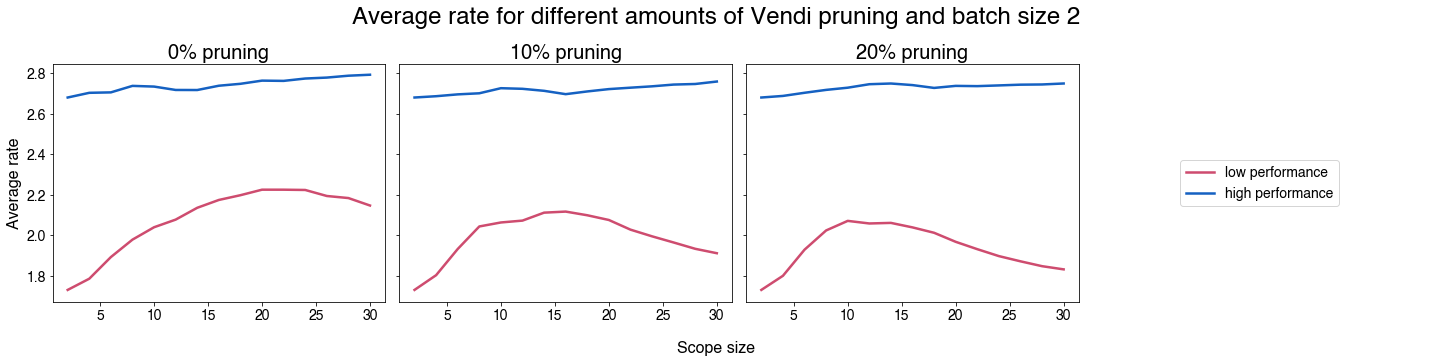

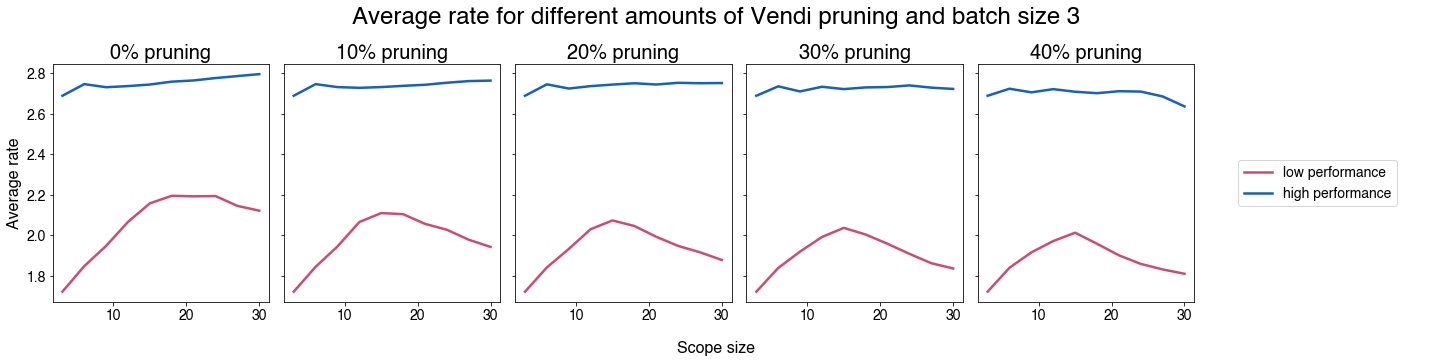

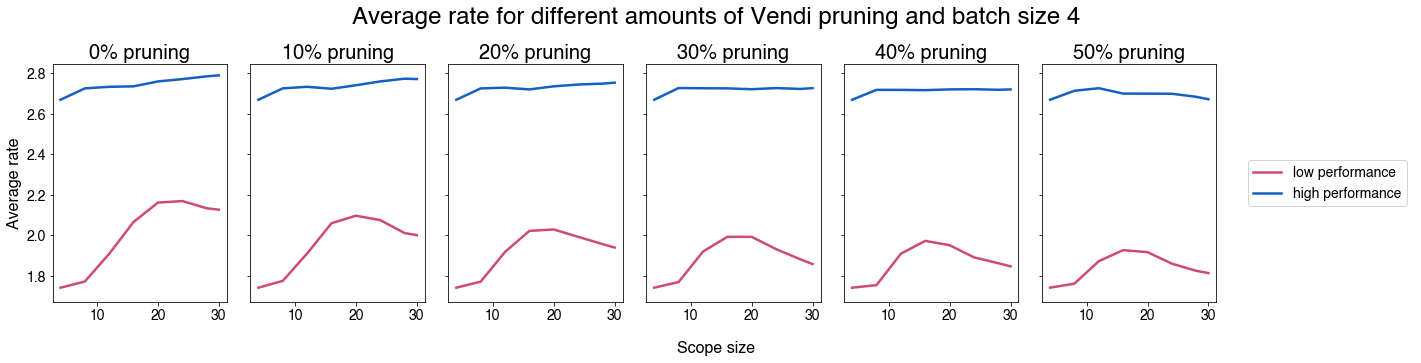

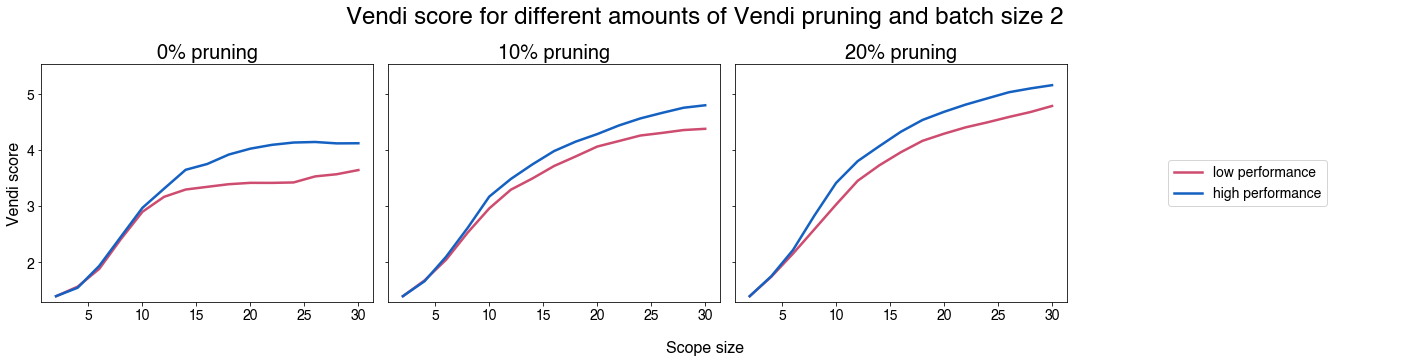

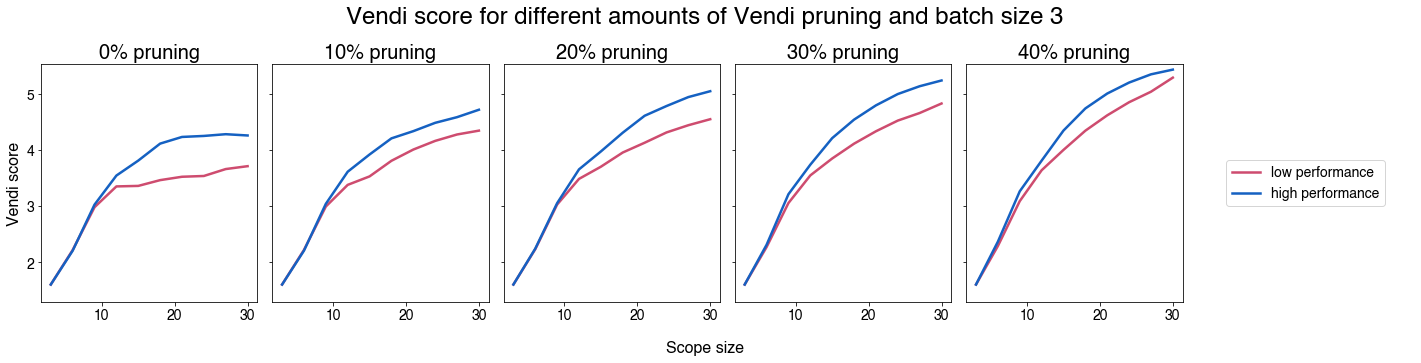

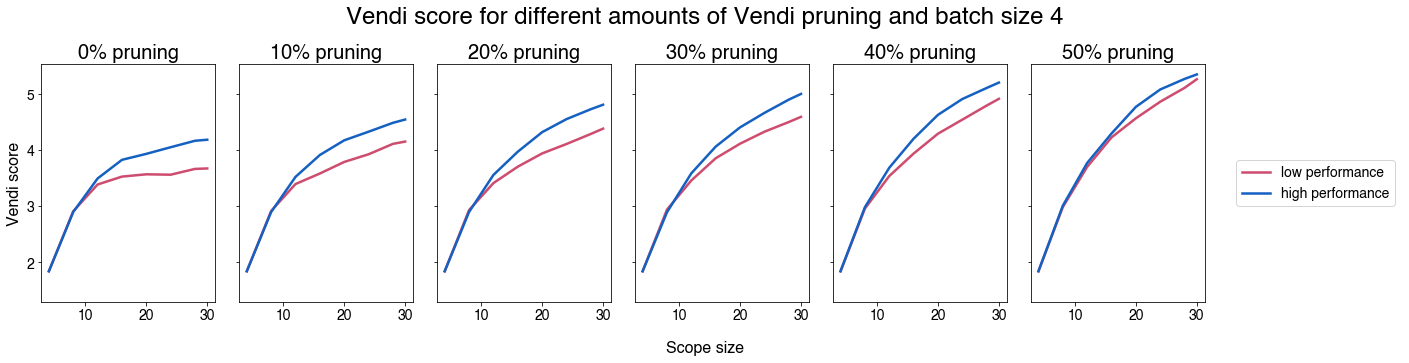

In [7]:
# Process the data
skewness = ["low_performance","high_performance"]
for type_results in ["Objective","Vendi"]:
    label = None
    dfs = {}
    for trend in skewness:
        for i in [2,3,4]:
                dfs_progress =  Benchmark().progress_plot(budget=30,type_results=type_results,
                                                                            name_results=f"./Results_Data/Distribution_Dependence/{trend}/30balanced_b{i}",
                                                                            show_plot=False)
                dfs[trend+f"_b{i}"] = dfs_progress["means"]

    # Concatenate the results
    df = pd.concat(dfs,axis=1)
    # Clean up the multi-index that resulted from concatenation
    df.columns = ["_".join(multiidx[0].split("_")[:2])+"_"+multiidx[1] for multiidx in df.columns]

    # Visualize them
    batch_pruning_combinations = {2: [0,10,20], 3: [0,10,20,30,40], 4: [0,10,20,30,40,50]}
    for batch in [2,3,4]:
        fig, axes = plt.subplots(1, len(batch_pruning_combinations[batch])+1, figsize=(20, 5), sharey=True)
        fig.supxlabel("Scope size",fontsize=16)
        if type_results == "Objective":
            fig.suptitle(f"Average rate for different amounts of Vendi pruning and batch size {batch}",fontsize=24)
            axes[0].set_ylabel("Average rate",fontsize=16)
        elif type_results == "Vendi":
            extreme_scores = (df.min().min(),df.max().max())
            fig.suptitle(f"Vendi score for different amounts of Vendi pruning and batch size {batch}")
            axes[0].set_ylabel("Vendi score",fontsize=16)
        for i,pruning in enumerate(batch_pruning_combinations[batch]):
            if type_results == "Objective":
                extreme_scores = (df.min().min()-0.05,df.max().max()+0.05)
            if type_results == "Vendi":
                extreme_scores = (df.min().min()-0.1,df.max().max()+0.1)
            df_plot = df.copy()
            df_plot = df_plot[[column for column in df.columns if ((f"b{batch}_V{pruning}") in column)]]
            df_plot.columns = [" ".join(col.split("_")[:2]) for col in df_plot.columns]
            for j,col in enumerate(df_plot.columns):
                style = '-' if j <= 6 else '--' if j <= 13 else ':'
                plotting = df_plot[col][df_plot[col].notna()]
                axes[i].plot(plotting.index, plotting.values, label = col, color=all_colors[j], linestyle=style, linewidth=2.5)
            axes[i].set_ylim(extreme_scores[0],extreme_scores[1])
            axes[i].set_title(f"{pruning}% pruning")
            if i == 0:
                handles_collected, labels_collected = axes[i].get_legend_handles_labels()
        axes[len(batch_pruning_combinations[batch])].axis('off')
        axes[len(batch_pruning_combinations[batch])].legend(handles=handles_collected, labels=labels_collected,
                                                            fontsize=14, loc='center')
        plt.tight_layout()
        plt.show()

Due to the different rate distributions, it is to be expected that the average rate in the low performance dataset will be lower. If there is no influence of the distribution on the general performance of the algorithm, parallel lines would be expected in the progress plots for the average raets. The average rate in the high-performance dataset slowly rises with increasing scope size. In contrast, the average rate in the low-performance dataset reaches a maximum value before decreasing again (or plateauing in the case of no Vendi pruning). There is therefore a difference in the behavior for the different dataset distributions. This behavior might be due to the algorithm identifying high performers and the Vendi pruning subsequently removing similar compounds of which there will be fewer in the low performance dataset than in the high performance dataset. The remaining samples in the low-performance dataset are therefore again lower performing, leading to the observed effects.

The Vendi scores achieved with the lower performing dataset are also lower than the ones obtained with the higher performing one. The difference in Vendi scores seems to decrease with increasing sample pruning.

In conclusion, the distribution of the objective values has a strong effect on the performance of the dataset. Therefore, parallel optimization of datasets with different distributions could enable a broader applicability of the algorithm as the objective distribution will not be known in a real-world example.